regularization with kl divergence leads to a normal distribution with mean close to 0 and std close to 1. why not simply use $||\mu||+||\sigma-1||$ then?

In [1]:
from typing import List, Tuple
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.decomposition import PCA

In [2]:
def create_loaders(
        batch_size: int,
        root: str = "../../data/mnist") -> Tuple[DataLoader, DataLoader]:
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])

    mnist_train = datasets.MNIST(
        root=root,
        train=True,
        download=True,
        transform=transform)
    mnist_test = datasets.MNIST(
        root=root,
        train=False,
        download=True,
        transform=transform)

    train_loader = DataLoader(
        dataset=mnist_train,
        batch_size=batch_size,
        shuffle=True)
    test_loader = DataLoader(
        dataset=mnist_test,
        batch_size=batch_size,
        shuffle=False)
    return train_loader, test_loader

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_ch,
            out_channels=in_ch,
            kernel_size=3,
            padding=1)
        self.rect = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=2,
            stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.rect(self.conv1(x))
        out = out + x  # residual
        return self.rect(self.conv2(out))


class Encoder(nn.Module):
    def __init__(self, chs: List[int]):
        super().__init__()
        self.blocks = nn.ModuleList()
        for i in range(len(chs) - 1):
            block = EncoderBlock(in_ch=chs[i], out_ch=chs[i + 1])
            self.blocks.append(block)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for block in self.blocks:
            x = block(x)
        return x

In [4]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=in_ch,
            kernel_size=3,
            padding=1)
        self.rect = nn.LeakyReLU()
        self.tconv = nn.ConvTranspose2d(
            in_channels=in_ch,
            out_channels=out_ch,
            output_padding=0,
            kernel_size=2,
            stride=2)

    def forward(self, x: torch.Tensor):
        out = self.rect(self.conv(x))
        out = out + x  # residual
        return self.rect(self.tconv(out))


class Decoder(nn.Module):
    def __init__(self, chs: List[int]):
        super().__init__()
        self.blocks = nn.ModuleList()
        for i in range(len(chs) - 1):
            block = DecoderBlock(in_ch=chs[i], out_ch=chs[i + 1])
            self.blocks.append(block)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for block in self.blocks:
            x = block(x)
        return x

In [5]:
class Distribution(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, encoding: torch.Tensor):
        pass

class Normal(Distribution):
    def __init__(self, ch: int):
        super().__init__()
        self.mean_lin = nn.Linear(in_features=ch, out_features=ch)
        self.std_lin = nn.Linear(in_features=ch, out_features=ch)

    def forward(
            self,
            encoding: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_dim = encoding.size(0)
        feature_dim = encoding.size(1) * encoding.size(2) * encoding.size(3)
        encoding_flat = torch.reshape(encoding, shape=[batch_dim, feature_dim])

        mean = self.mean_lin(encoding_flat)
        std = torch.exp(self.std_lin(encoding_flat))
        noise = torch.randn(size=std.shape)
        dist = mean + (std * noise)
        dist_reshaped = torch.reshape(dist, shape=encoding.shape)

        regul_mean = torch.norm(mean - torch.zeros_like(mean)) / mean.numel()
        regul_std = torch.norm(std - torch.ones_like(std)) / std.numel()
        return dist_reshaped, regul_mean + regul_std


class VAE(nn.Module):
    def __init__(
            self,
            chs: List[int],
            distribution: Distribution,
            regul_strength: float):
        super().__init__()
        self.encoder = Encoder(chs=chs)
        self.distribution = distribution
        self.decoder = Decoder(chs=list(reversed(chs)))
        self.regul_strength = regul_strength
        self.loss_reconstruct = nn.MSELoss()

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> dict:
        encoding = self.encoder(x)
        distribution, regul = self.distribution(encoding)
        decoding = self.decoder(distribution)
        loss = self.loss_reconstruct(decoding, y)
        return {"scores": decoding, "loss": loss + self.regul_strength * regul}

In [6]:
def train(
        module: nn.Module,
        loader: DataLoader,
        lrs: List[float],
        device: str,
        n_epochs: int) -> List[float]:
    optimizer = torch.optim.Adam(params=module.parameters(), lr=lrs[0])
    module.train()
    losses = []
    for i in range(n_epochs):
        print("epoch", i + 1)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lrs[i]
        for batch in loader:
            img = batch[0].to(device)
            loss = module(x=img, y=img)["loss"]
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return losses

In [7]:
batch_size = 128
n_epochs = 5
# 1 warmup epoch, 3 epochs with decreasing lr
lrs = [0.00001] + [0.001 * (0.95**i) for i in range(n_epochs - 1)]
chs = [1, 16, 32, 64, 128, 256]
regul_strength = 1
device = "cpu"

loader_train, loader_test = create_loaders(batch_size=batch_size)
print(len(loader_train), "train batches")
print(len(loader_test), "val batches")

469 train batches
79 val batches


In [8]:
vae = VAE(chs=chs,
          distribution=Normal(ch=chs[-1]),
          regul_strength=regul_strength)
losses = train(module=vae,
               loader=loader_train,
               lrs=lrs,
               device=device,
               n_epochs=n_epochs)

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5


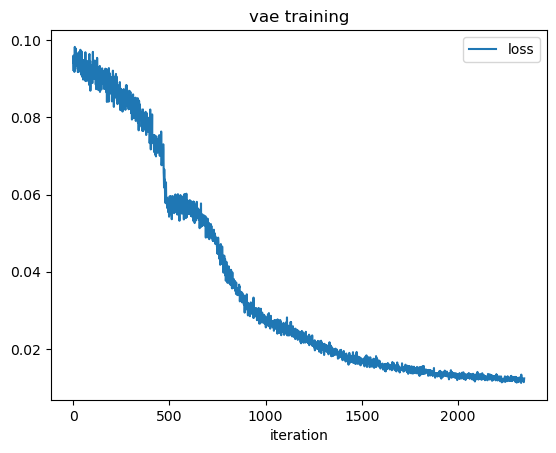

In [9]:
plt.plot(range(len(losses)), losses, label="loss")
plt.xlabel("iteration")
plt.title("vae training")
plt.legend()
plt.show()

# latent feature space exploration

In [10]:
vae.eval()
encoder = vae.encoder
distribution = vae.distribution
decoder = vae.decoder
batch = next(iter(loader_test))

## multiple variations of the same encoding
- due to reparameterization, multiple (slightly different) decodings of the same input can be created

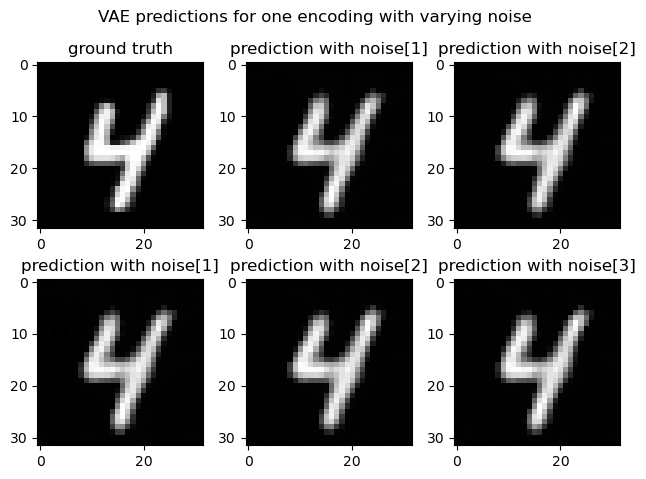

In [22]:
image = batch[0][3]
encoding = encoder(image.unsqueeze(0))
dist_4, _ = distribution(encoding)

images = [image]
subplot_titles = ["ground truth"]
for i in range(5):
    dist, _ = distribution(encoding)
    out = decoder(dist)
    images.append(out[0])
    subplot_titles.append(f"prediction with noise[{i + 1}]")

fig, axs = plt.subplots(nrows=2, ncols=3)
for i in range(2):
    for j in range(3):
        axs[i][j].imshow(images[i + j][0].detach(), cmap='gray')
        axs[i][j].set_title(subplot_titles[i + j])
fig.suptitle("VAE predictions for one encoding with varying noise")
plt.tight_layout()
plt.show()

## interpolating between two encodings
- latent space is more continuous than that learned by a vanilla autoencoder

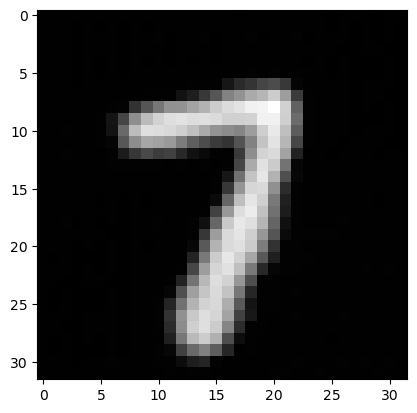

In [28]:
image = batch[0][6]
dist_7, _ = distribution(encoder(image.unsqueeze(0)))
plt.imshow(decoder(dist_7)[0][0].detach(), cmap='gray')
plt.show()

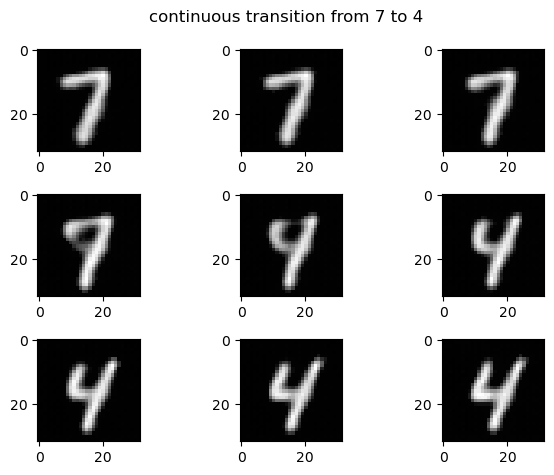

In [30]:
weights = torch.linspace(start=0, end=1, steps=9).resize(3,3)
fig, axs = plt.subplots(ncols=3, nrows=3)
for i in range(3):
    for j in range(3):
        img = decoder(torch.lerp(dist_7, dist_4, weight=weights[i, j]))[0].detach()
        axs[i][j].imshow(img[0], cmap='gray')
fig.suptitle("continuous transition from 7 to 4")
plt.tight_layout()
plt.show()

## latent space visualization
- despite heavy dimensionality reduction to 3 principal components, it is still visible that classes are roughly clustered

In [14]:
dists = []
classes = []
for batch in loader_test:
    encodings_batch = encoder(batch[0])
    dists_batch, _ = distribution(encodings_batch)
    dists.append(dists_batch.detach())
    classes.append(batch[1])
dists = torch.cat(dists).squeeze().numpy()
classes = torch.cat(classes).squeeze()

pca = PCA(n_components=3)
dists_reduced = pca.fit_transform(dists)

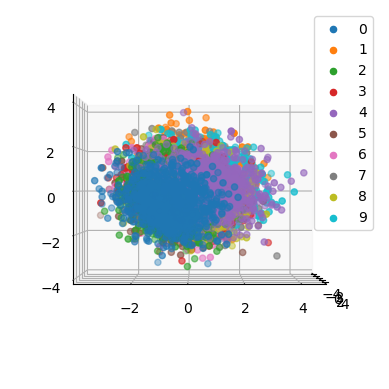

In [15]:
azim = 0
ax = plt.axes(projection='3d')
ax.view_init(elev=0, azim=azim)
for class_id in range(10):
    points = dists_reduced[classes == class_id]
    ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], label=str(class_id))
plt.legend()
plt.savefig(f"../../monitoring/autoencoder/vae_azim{azim}")

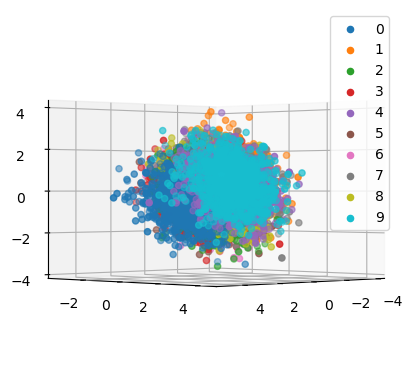

In [16]:
azim = 45
ax = plt.axes(projection='3d')
ax.view_init(elev=0, azim=azim)
for class_id in range(10):
    points = dists_reduced[classes == class_id]
    ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], label=str(class_id))
plt.legend()
plt.savefig(f"../../monitoring/autoencoder/vae_azim{azim}")

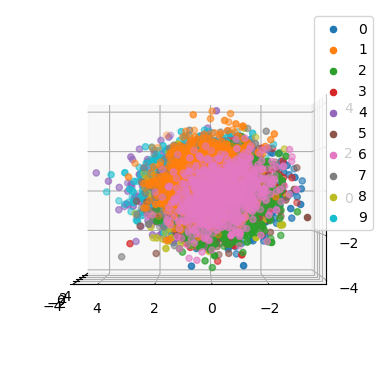

In [17]:
azim = 180
ax = plt.axes(projection='3d')
ax.view_init(elev=0, azim=azim)
for class_id in range(10):
    points = dists_reduced[classes == class_id]
    ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], label=str(class_id))
plt.legend()
plt.savefig(f"../../monitoring/autoencoder/vae_azim{azim}")